# Assignment 2
I'll start by including some of the libraries I'll be needing throughout this

In [1]:
using Roots,QuantEcon,NLsolve,Parameters,Gadfly,DataFrames,LinearAlgebra,Cairo,Fontconfig #Need these last two for Gadfly to produce png
set_default_plot_size(40cm,20cm)
Gadfly.push_theme(Theme(major_label_font_size=20pt,minor_label_font_size=14pt,key_label_font_size=16pt,
                        line_width=2pt,point_size=3pt))

## Part 1
We can rewrite equation (3) of the assignment as 
$$
\max_{P_{i,t}} \sum_{t=0}^\infty \beta^t\left(\left[\frac{P_{i,t}}{a_{i,t}\bar W}-1\right]a_{i,t}\bar Wa_{i,t}^{\gamma-1}\left(P_{i,t}\right)^{-\gamma}-\bar W^{1-\gamma}\kappa1_{P_{i,t}\neq P_{i,t-1}}\right)
$$
We note that $a_{i,t}\bar Wa_{i,t}^{\gamma-1}\left(P_{i,t}\right)^{-\gamma} = \left(\frac{P_{i,t}}{a_{i,t}\bar W}\right)^{-\gamma}\bar W^{1-\gamma}$ and then substitute for $\mu_{i,t} = \frac{P_{i,t}}{a_{i,t}\bar W}$
to get
$$
\max_{P_{i,t}} \sum_{t=0}^\infty \beta^t\left(\left[\mu_{i,t}-1\right]\mu_{i,t}^{-\gamma}\bar W^{1-\gamma}-\bar W^{1-\gamma}\kappa1_{P_{i,t}\neq P_{i,t-1}}\right)
$$
By definition of $\mu_{i,t}$ we have that $P_{i,t}=P_{i,t-1}$ only if $\mu_{i,t} = \mu_{i,t-1}\frac{a_{i,t-1}}{a_{i,t}} = \mu_{i,t}\exp(-\epsilon_{i,t})$.  We therefore conclude that
$$
\bar W^{1-\gamma}\max_{\mu_{i,t}}\sum_{t=0}^\infty \beta^t\left([\mu_{i,t}-1]\mu_{i,t}^{-\gamma}-\kappa1_{\mu_{i,t}\neq \frac{\mu_{i,t-1}}{\exp(\epsilon_{i,t})}}\right)
$$
Note, we have pulled out the factor of $\bar W^{1-\gamma}$ since it does not affect the maximization.
## Part 2
Let $V(\mu)$ be the value of a firm entering with markup $\mu$ which chooses not to change prices this period.  
Let $J$ be the value of a firm which elects to change prices this period.  We know that $V(\mu)$ satisfies (since the firm choose not to change prices)
$$
V(\mu) = (\mu-1)\mu^{-\gamma} + \beta \mathbb E\max\left\{V\left(\frac{\mu}{\exp(\epsilon')}\right),J\right\}
$$
where the expectation is over the random variable $\epsilon'$.  For the value $J$, the firm is choosing the optimal price $\mu^*$ this period, while paying a cost $\kappa$,
$$
J = \max_{\mu^*} (\mu^*-1)(\mu^*)^{-\gamma} -\kappa + \beta \mathbb E\max\left\{V\left(\frac{\mu^*}{\exp(\epsilon')}\right),J\right\}
$$
we note that this simplifies to 
$$
J = \max_{\mu^*}V(\mu^*) -\kappa.
$$
## Part 3
We start by setting up struct holding all the elements we need for the firm's problem

In [2]:
using BasisMatrices,LinearAlgebra,Parameters,Optim,Gadfly,FastGaussQuadrature,StatsBase,DataFrames

@with_kw mutable struct FirmProblem
    #Parameters
    γ::Float64 = 3.
    κ::Float64 = .05
    β::Float64 = 0.9981
    σ_ε::Float64 = 0.1
    N_ε::Int = 10 #number of quadrature points

    #Quadrature Nodes
    ε::Vector{Float64} = zeros(0)
    πε::Vector{Float64} = zeros(0)
    
    #Value function solutions
    V::Interpoland
    J::Float64
    μstar::Float64 = 0. #optimal markup
end;

I'm going to write a custom constructor to setup the firms problem for a given set of parameters

In [3]:
"""
    FirmProblem()   

Constructs the default calibration for the firm problem
"""
function FirmProblem(κ=.05,σ_ε=0.1,γ=3.,β=0.9981,Nμ=100)
    μstar = γ/(γ-1) #markup chosen if κ = 0.
    μgrid = LinRange(μstar*0.2,μstar*2.,Nμ) #grid over $\mu$ chosen to never bind
    V = Interpoland(SplineParams(μgrid,0,1),μ->(μ.-1).*μ.^(-γ)./(1-β)) #guess for V
    J = (μstar - 1)*μstar^(-γ)/(1-β) - κ#Guess for J
    
    fp = FirmProblem(γ=γ,κ=κ,β=β,V=V,J=J)
    #setup gausshermite quadrature nodes for integration
    ξ,w = gausshermite(fp.N_ε)
    fp.ε = sqrt(2)*σ_ε*ξ
    fp.πε = w./sum(w)
    fp.σ_ε = σ_ε
    return fp
end;

Next we write code to solve iterate on the bellman equation of the firm

In [4]:
"""
    iterateBellman!(fp::FirmProblem,Vprime,Jprime)

Iterates on the firm's bellman equation given a continuation values Vprime and Jprime
"""
function iterateBellman!(fp::FirmProblem,Vprime,Jprime)
    @unpack γ,β,ε,πε,κ = fp
    μbasis = Vprime.basis
    μgrid = nodes(μbasis)[1]
    Vgrid = zeros(length(μgrid))
    #first compute V
    for (i,μ) in enumerate(μgrid)
        μ′ = μ./exp.(ε)
        Vgrid[i] = (μ-1)*μ^(-γ) + β*dot(πε,max.(Vprime(μ′),Jprime))
    end
    V = Interpoland(μbasis,Vgrid)

    # Now compute J by maximizing over V
    res =  Optim.maximize(V,μgrid[1],μgrid[end])
    J = maximum(res) - κ
    fp.μstar = Optim.maximizer(res)
    return V,J
end;

Finally we need the code to solve the bellman equation of the firm

In [5]:
"""
    solveBellman!(fp::FirmProblem)

Solves the firm's bellman equation using fp.V and fp.J as initial values
"""
function solveBellman!(fp::FirmProblem)
    diff = 1.
    
    while diff > 1e-7
        V,J = iterateBellman!(fp,fp.V,fp.J)

        diff = max(norm(V.coefs-fp.V.coefs,Inf),abs(J-fp.J))

        fp.V = V
        fp.J = J
    end
end;

Running code at default calibration

In [6]:
fp = FirmProblem() #use default calibration
solveBellman!(fp);

## Part 4
Finding when the firms change prices is as easy as plotting $V$ relative to $J$

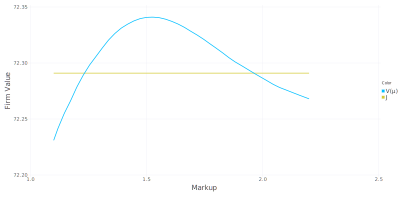

In [7]:
Vplot = layer(x->fp.V(x),1.1,2.2,color=["V(μ)"])
Jplot = layer(x->fp.J,1.1,2.2,color=["J"])
plot(Vplot,Jplot,Guide.xlabel("Markup"),Guide.ylabel("Firm Value"))

We see that outside of the range markup range [1.2,1.95] the value of a firm is greater when they change prices.
The firm will therefore change prices when it goes outside of this range of markups and keep it's prices constant inside that range.
## Part 5
The code to simulate $N$ firms for $T$ periods below.  Given some initial distribution $\mu_0$.

In [8]:
"""
    simulateFirms(fp,N,μ0,T)

Simulate N firms for T periods from initial distribution  μ0
"""
function simulateFirms(fp,N,μ0,T)
    @unpack V,J,μstar,σ_ε,γ = fp

    μ = copy(μ0)
    df = DataFrame(zeros(T,3),[:P,:Δ,:frac_change])
    for t in 1:T
        μ ./= exp.(σ_ε.*randn(N)) #price shock
        change = J .> V(μ)
        
        Δ = @views μstar ./ μ[change] .- 1
        μ[change] .= μstar
        P = mean(μ.^(1-γ))^(1/(1-γ)) 
        df.P[t] = P #average price level
        df.Δ[t] = mean(abs.(Δ)) #Average size of price change
        df.frac_change[t] = sum(change)/N #Fraction of firms changing prices
    end

    #return path of aggregates and distribution
    return df,μ
end;

Plotting the path of the moments we're interested in we find that the distribution quickly converges to steady state

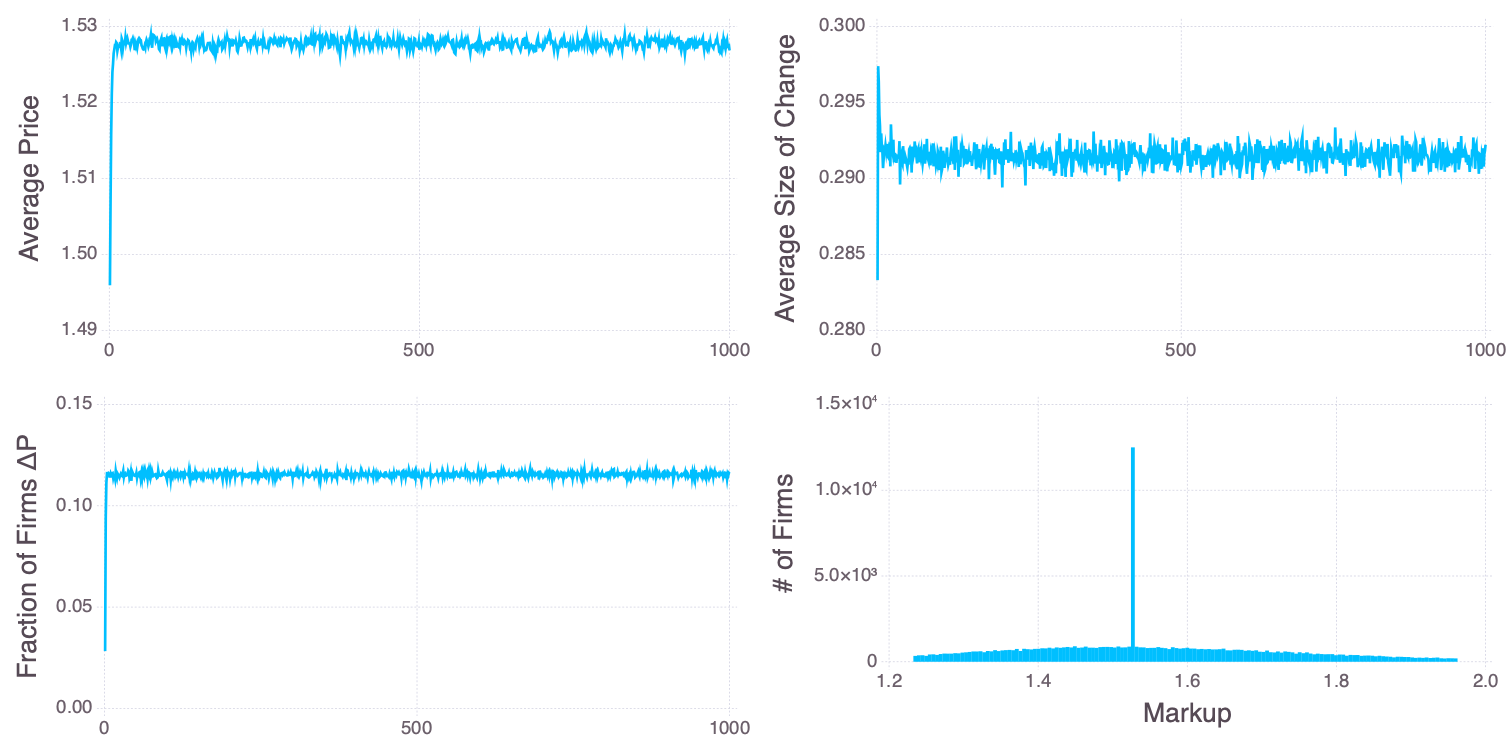

In [9]:
N = 100_000
df,μ = simulateFirms(fp,N,1.5*ones(N),1000)
p1 = plot(df,y=:P,Geom.line,Guide.ylabel("Average Price"))
p2 =plot(df,y=:Δ,Geom.line,Guide.ylabel("Average Size of Change"))
p3 = plot(df,y=:frac_change,Geom.line,Guide.ylabel("Fraction of Firms ΔP"))
p4 = plot(x=μ,Geom.histogram,Guide.ylabel("# of Firms"),Guide.xlabel("Markup"))
gridstack([p1 p2;p3 p4])

but for this calibration we're not hitting the right moments.  Playing around with the parameters I found that this calibration worked well

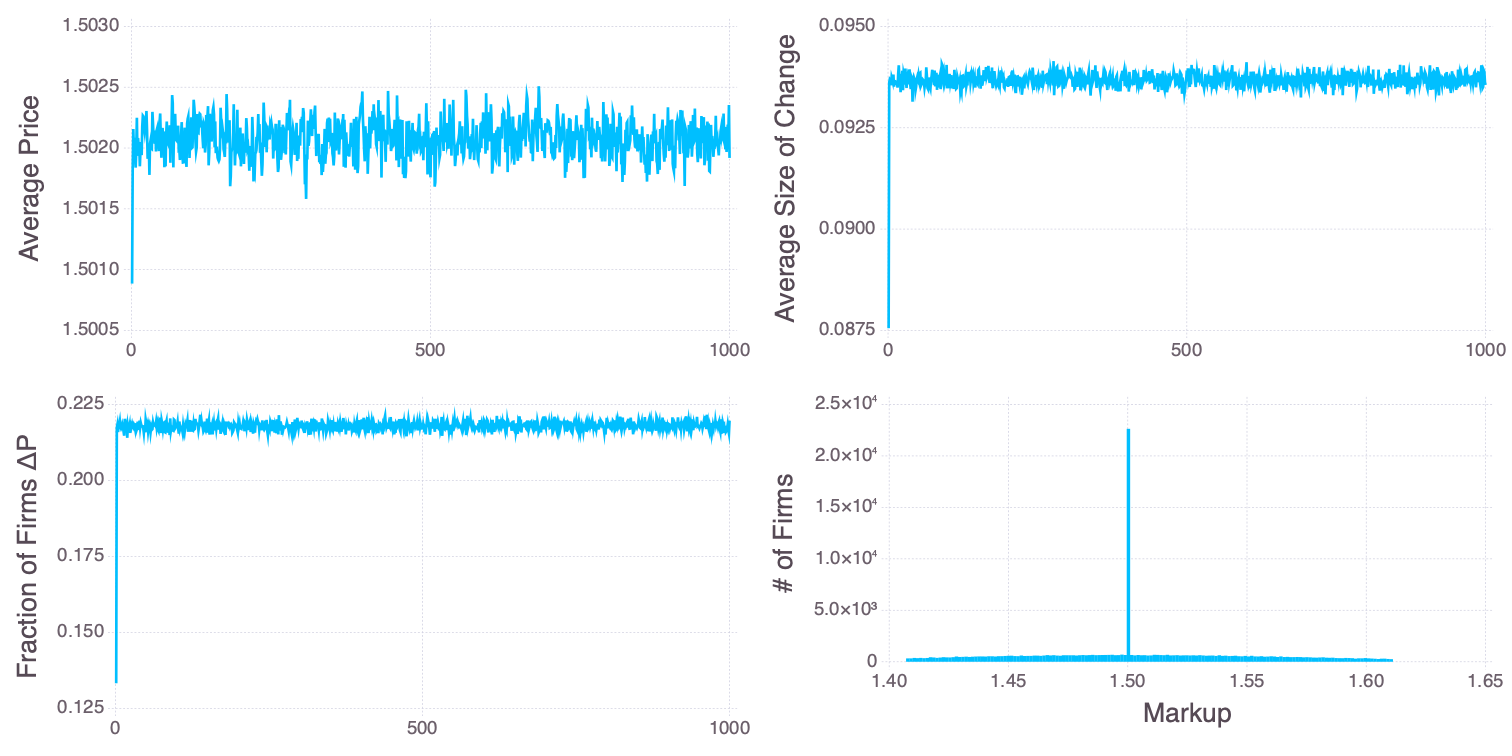

In [10]:
fp = FirmProblem(0.003,0.045)
solveBellman!(fp)
df,μ = simulateFirms(fp,N,1.5*ones(N),1000)
p1 = plot(df,y=:P,Geom.line,Guide.ylabel("Average Price"))
p2 =plot(df,y=:Δ,Geom.line,Guide.ylabel("Average Size of Change"))
p3 = plot(df,y=:frac_change,Geom.line,Guide.ylabel("Fraction of Firms ΔP"))
p4 = plot(x=μ,Geom.histogram,Guide.ylabel("# of Firms"),Guide.xlabel("Markup"))
gridstack([p1 p2;p3 p4])

## Part 6
Now start at steady state distribution $\mu$ computed above.  Change in wages decreases all markups by 5%.  We then plot the average path of prices

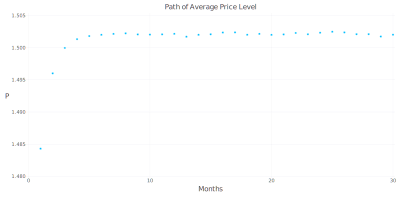

In [11]:
df_irf,μ̂ = simulateFirms(fp,N,μ./1.05,30)
plot(df_irf,y=:P,Guide.title("Path of Average Price Level"),Guide.xlabel("Months"))

We can see that firms quickly pass through the change in the increase in costs.  After 4 months the price level returns to it's steady state level.  This is 
much faster than a calvo model targeting the same fraction of firms changing prices every month.  General equilibrium model closer to money neutrality.